In [1]:
import numpy as np
import pandas as pd
import re
import dill as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from eval import *
from pandas.io.json import json_normalize
from copy import deepcopy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

sns.set_style('whitegrid')
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 300

In [2]:
from keras.models import load_model

Using TensorFlow backend.


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

## Apply trained model to the test data

In [4]:
feats = pickle.load(open('data/feats.pkl', 'rb'))

# Categorical features
cat_ix_trn, cat_ix_dev, cat_ix_test, cat_ix_trn_dev = feats['cat_ix_trn'], feats['cat_ix_dev'], feats['cat_ix_test'], feats['cat_ix_trn_dev']

# Numerical features
cont_trn, cont_dev, cont_test, cont_trn_dev = feats['cont_trn'], feats['cont_dev'], feats['cont_test'], feats['cont_trn_dev']

# Labels
y_trn_oh, y_dev_oh, y_test_oh, y_trn_dev_oh = feats['y_trn_oh'], feats['y_dev_oh'], feats['y_test_oh'], feats['y_trn_dev_oh']

# Supporting data
cat_vars, cont_vars = feats['cat_vars'], feats['cont_vars']
cat_mappers = feats['cat_mappers']
max_len_trn, max_len_dev, max_len_test = feats['max_len_trn'], feats['max_len_dev'], feats['max_len_test']

In [5]:
# Load model
rnn_trn_dev_combined = load_model('models/gru_trn_dev_combined.h5')

In [6]:
# Apply model to evaluate results
def predict_and_eval(x, y, model, track_itos=None, per_track=True):
    # Generate predictions (may take a while...)
    y_pred_prob = model.predict(x)
    
    # Reshape to 2D (thus concatenating all observations together)
    y_rs = y.reshape(-1, 3)
    y_pred_prob_rs = y_pred_prob.reshape(-1, 3)

    # Remove padded observations
    # (the first vertical axis indicates whether it's a padded observation or not)
    non_pad_ix = np.where(y_rs[:, 0] == 0)[0]
    y_rs = y_rs[non_pad_ix, :]
    y_pred_prob_rs = y_pred_prob_rs[non_pad_ix, :]
    
    # Only evaluate on the positive class
    y_rs = y_rs[:, -1]
    y_pred_prob_rs = y_pred_prob_rs[:, -1]
    
    # Put together in a dataframe
    y_pred_df = pd.DataFrame({'actual': y_rs, 'predicted': y_pred_prob_rs})
    
    # Compute metrics per track
    if per_track:
        # Add track
        track_rs = x[0].flatten()  # The first element of the feature list is `track`
        track_rs = track_rs[non_pad_ix]
        y_pred_df['track'] = [track_itos[t] for t in track_rs]    
        
        metrics_per_track = y_pred_df.groupby('track').apply(lambda grp: evaluate_metrics(grp['actual'].values, grp['predicted'].values))
        return json_normalize(metrics_per_track).set_index(metrics_per_track.index)[['auroc', 'F1']]
    else:
        metrics = evaluate_metrics(y_pred_df['actual'].values, y_pred_df['predicted'].values)
        return json_normalize(metrics)[['auroc', 'F1']]

In [7]:
# Put together test data
x_test = [cat_ix_test[var] for var in cat_vars] + [cont_test[var] for var in cont_vars]

In [8]:
# Generate and evaluate predictions using the model trained with both the training and dev data
metrics_test_rnn_trn_dev_combined = predict_and_eval(x_test, y_test_oh, rnn_trn_dev_combined, cat_mappers['track']['itos'])
metrics_test_rnn_trn_dev_combined

,auroc,F1
track,,
en_es,0.834715,0.450294
es_en,0.800922,0.394880
fr_en,0.826375,0.473057


## Analyze feature importance

In [9]:
def estimate_feat_importance(x, y, model, feats_order, n_timesteps=None, n_samples=None, seed=0):
    # Due to the amount of time it takes to run,
    # only generate predictions on the last N timesteps
    if n_timesteps:
        x = [xi[:, -n_timesteps:] for xi in x]
        y = y[:, -n_timesteps:, :]
    
    # Simiarly, sample a few observations to generate predictions on
    if n_samples:
        np.random.seed(seed)
        ix = np.random.choice(np.arange(len(x[0])), n_samples, replace=False)
        x = [xi[ix] for xi in x]
        y = y[ix]
    
    print('Evaluating on {} observations with {} most recent timesteps.'.format(y.shape[0], y.shape[1]))
    
    # Compute baseline metrics using unshuffled data
    baseline = predict_and_eval(x, y, model, per_track=False)
    print('Baseline computed.')
    
    # Generate shuffled index
    ix = np.arange(len(y))
    np.random.seed(seed)
    np.random.shuffle(ix)
    
    metrics_change = {}
    
    # Shuffle by feature
    for i, f in enumerate(feats_order):
        if i % 5 == 0 and i > 0:
            print('{} features processed, {} to go...'.format(i, len(feats_order) - i - 1))
        save = deepcopy(x[i])
        
        # Shuffle selected features
        x[i] = x[i][ix]
        
        # Re-compute metrics
        new_score = predict_and_eval(x, y, model, per_track=False)
        
        # Compute differences
        metrics_change[f] = baseline - new_score
        
        # Restore the original value
        x[i] = save

    return metrics_change

In [10]:
# Use validation data
x_dev = [cat_ix_dev[var] for var in cat_vars] + [cont_dev[var] for var in cont_vars]
feats_order = cat_vars + cont_vars

In [13]:
# Estimate importance for each feature
# (using the model trained on the training data only)
n_timesteps = 100
n_samples = 1000

rnn = load_model('models/gru.h5')
rnn_feat_imp = estimate_feat_importance(x_dev, y_dev_oh, rnn, feats_order, n_timesteps, n_samples)

Evaluating on 1000 observations with 100 most recent timesteps.
Baseline computed.
5 features processed, 24 to go...
10 features processed, 19 to go...
15 features processed, 14 to go...
20 features processed, 9 to go...
25 features processed, 4 to go...


In [14]:
# Consolidate
for f, m in rnn_feat_imp.items():
    m.index = [f]

rnn_feat_imp = pd.concat(list(rnn_feat_imp.values()))
rnn_feat_imp.columns = 'Decrease in ' + rnn_feat_imp.columns
rnn_feat_imp.sort_values(['Decrease in auroc', 'Decrease in F1'], inplace=True)

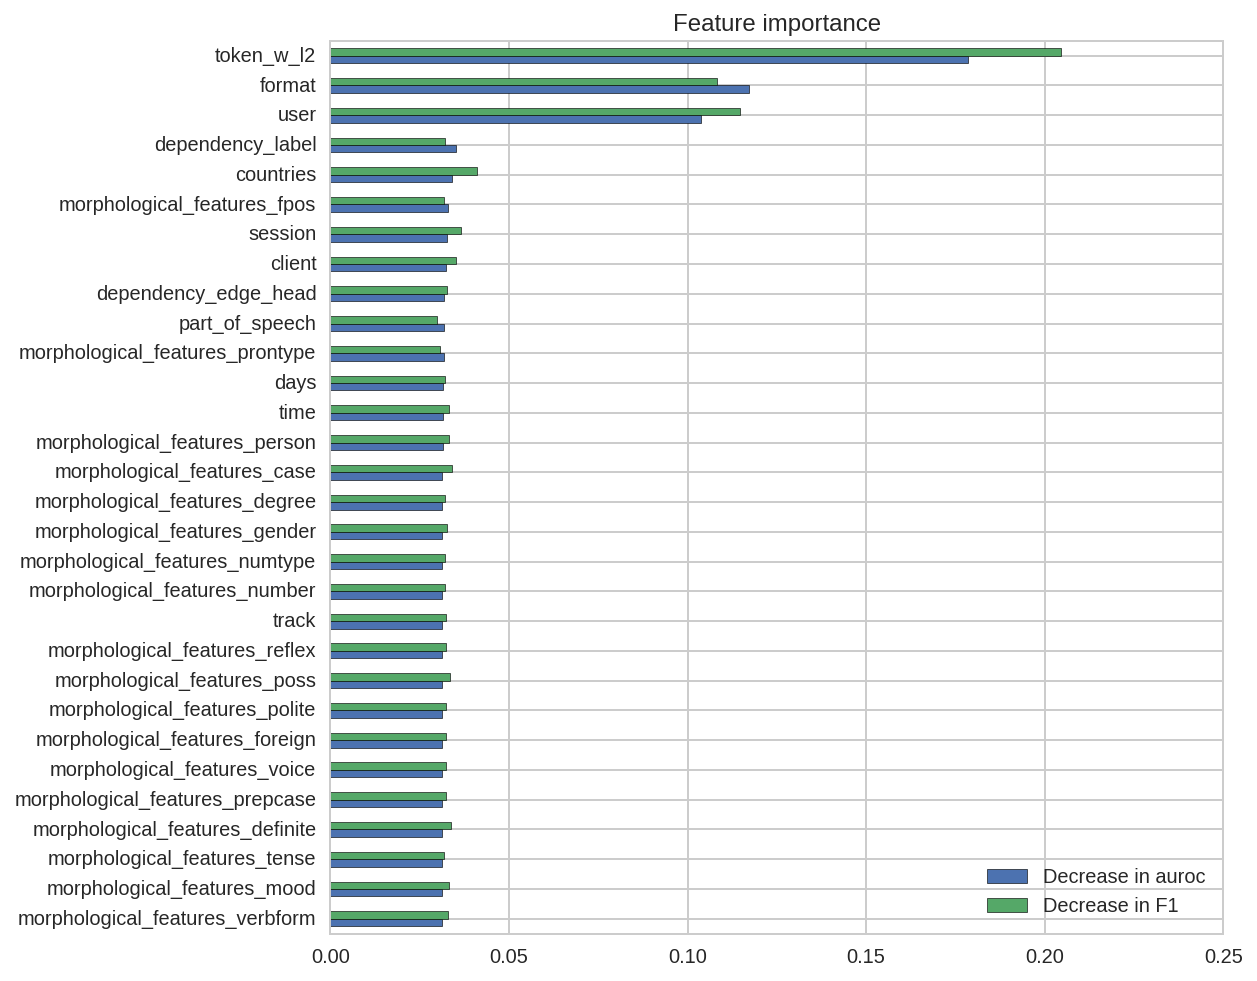

In [15]:
# Plot
rnn_feat_imp.plot(kind='barh', title='Feature importance', figsize=(8, 8))

## Analyze embeddings

In [262]:
def analyze_embeddings(model, var, x_dict, y):
    # Extract embeddings
    embeddings = model.get_layer('embeded_' + var).get_weights()[0]

    # Reduce dimensions to 2
    if embeddings.shape[1] > 2:
        if embeddings.shape[1] >= 100:
            embeddings = PCA(n_components=50).fit_transform(embeddings)
        embeddings = TSNE(n_components=2, init='pca').fit_transform(embeddings)
    
    # Convert to dataframe
    embeddings = pd.DataFrame(embeddings, columns=['x', 'y'])
    
    # Compute summary statistics from the feature data
    x = x_dict[var]
    
    # Reshape to concatenate all observations together
    x_rs = x.flatten()
    y_rs = y.reshape(-1, 3)

    # Remove padded observations
    # (the first vertical axis indicates whether it's a padded observation or not)
    non_pad_ix = np.where(y_rs[:, 0] == 0)[0]
    x_rs = x_rs[non_pad_ix]
    y_rs = y_rs[non_pad_ix, :]

    # Only keep the last dimension (i.e., the positive label)
    y_rs = y_rs[:, -1]
    
    # Combine the selected variable with the label
    xy = pd.DataFrame({var: x_rs, 'label': y_rs})
    
    # Aggregate by the variable
    xy_agg = xy.groupby(var).agg(['count', 'mean'])
    xy_agg.columns = xy_agg.columns.levels[1]
    
    # Break the summary stats into quantiles (for ease of visualizations)
    xy_agg['mean_grp'] = pd.qcut(xy_agg['mean'], 9, duplicates='drop').astype(str)

    # Join to the TSNE result
    xy_agg_w_embed = xy_agg.join(embeddings)
    
    return xy_agg_w_embed

In [184]:
# Token embeddings
embeddings_token_w_l2 = analyze_embeddings(rnn_trn_dev_combined, 'token_w_l2', cat_ix_trn_dev, y_trn_dev_oh)
embeddings_token_w_l2.shape

(6177, 4)

In [272]:
%%R -i embeddings_token_w_l2
library(ggplot2)

embeddings_token_w_12_plt =
    ggplot(embeddings_token_w_l2, aes(x = x, y = y, colour = mean_grp)) +
    geom_point(alpha = .3) +
    scale_colour_brewer(type = 'seq', palette = 'Blues', direction = 1, name = 'Average error rate') +
    coord_fixed() +
    ggtitle('2D visualization of the token embeddings') +
    theme_bw()

ggsave(embeddings_token_w_12_plt, filename='plots/embeddings_token_w_12_plt.png', width = 7, height = 6)

In [188]:
# user embeddings
embeddings_user = analyze_embeddings(rnn_trn_dev_combined, 'user', cat_ix_trn_dev, y_trn_dev_oh)
embeddings_user.shape

(6447, 4)

In [275]:
%%R -i embeddings_user
library(ggplot2)

embeddings_user_plt =
    ggplot(embeddings_user, aes(x = x, y = y, colour = mean_grp)) +
    geom_point(alpha = .3) +
    scale_colour_brewer(type = 'seq', palette = 'Blues', direction = 1, name = 'Average error rate') +
    coord_fixed() +
    ggtitle('2D visualization of the user embeddings') +
    theme_bw()

ggsave(embeddings_user_plt, filename='plots/embeddings_user.png', width = 7, height = 5)